In [1]:

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import cv2
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import cohen_kappa_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
import os
import random
import time
import pickle
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' 

2025-08-05 06:06:43.132686: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-05 06:06:43.251837: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754388403.296311    4962 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754388403.309483    4962 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754388403.419176    4962 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
!ipynb-py-convert confusion.ipynb plot.py

In [3]:
# random seeds 
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(42)

# Noi luu tru model sau khi huan luyen
os.makedirs('models', exist_ok=True)

# Configuration
IMAGE_SIZE = 256
BATCH_SIZE = 16
NUM_CLASSES = 5
RANDOM_STATE = 42

In [4]:
# ================== IMAGE PREPROCESSING FUNCTIONS ==================
# tang tuong phan cuc bo
def apply_CLAHE(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    return cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

# chinh sang toi
def adjust_gamma(img, gamma=1.5):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(img, table)
# tang tuong phan toan cuc
def global_hist_equal(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
# lam min vien
def smooth_bilateral(img):
    return cv2.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)

def addWeighted(img,sigmaX=10):
    return cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), sigmaX), -4, 128)
    
def enhance_fundus(img):
    img = apply_CLAHE(img)
    img = adjust_gamma(img, gamma=1.2)
    # img = cv2.GaussianBlur(img, (3, 3), 0)
    return img
def enhance_fundus2(img):
    img = apply_CLAHE(img)
    img = adjust_gamma(img, gamma=2)
    
    img = global_hist_equal(img)
    img = smooth_bilateral(img)
    return img

def crop_black(img, tol=7):
# ham xoa khoang den
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        check_shape = img[:,:,0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        
        if check_shape == 0:
            return img
        else:
            img1 = img[:,:,0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:,:,1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:,:,2][np.ix_(mask.any(1), mask.any(0))]
            img = np.stack([img1, img2, img3], axis=-1)
            return img

def circle_crop(img, sigmaX=10):
# cat theo hinh tron
    height, width, depth = img.shape
    
    largest_side = np.max((height, width))
    img = cv2.resize(img, (largest_side, largest_side))
    
    height, width, depth = img.shape
    
    x = int(width / 2)
    y = int(height / 2)
    r = np.amin((x, y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    
    img = cv2.bitwise_and(img, img, mask=circle_img)
    return img

def random_crop(img, size=(0.9, 1)):
    height, width, depth = img.shape
    
    cut = 1 - random.uniform(size[0], size[1])
    
    i = random.randint(0, int(cut * height))
    j = random.randint(0, int(cut * width))
    h = i + int((1 - cut) * height)
    w = j + int((1 - cut) * width)
    
    img = img[i:h, j:w, :]
    
    return img

def prepare_image(path, sigmaX=10, do_random_crop=False):
    
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # cat den
    image = crop_black(image, tol=7)
    if do_random_crop:
        image = random_crop(image, size=(0.9, 1))
    
    # Resize and color enhancement
    image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))  
    image = addWeighted(image)
    
    #cat tron
    image = circle_crop(image, sigmaX=sigmaX)
    
    # Normalize to [0, 1]
    image = image.astype(np.float32) / 255.0
    
    return image


In [5]:
# ================== CUSTOM DATA GENERATOR ==================

class DiabeticsDataGenerator(keras.utils.Sequence):
    def __init__(self, data, directory, batch_size=32, image_size=256, 
                 shuffle=True, augment=False, itype='.png'):
        self.data = data.reset_index(drop=True)
        self.directory = directory
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.itype = itype
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = self.data.iloc[batch_indexes]
        
        X, y = self.__data_generation(batch_data)
        return X, y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __data_generation(self, batch_data):
        X = np.empty((self.batch_size, self.image_size, self.image_size, 3), dtype=np.float32)
        y = np.empty((self.batch_size,), dtype=int)
        
        for i, (idx, row) in enumerate(batch_data.iterrows()):
            img_path = os.path.join(self.directory, row['id_code'] + self.itype)
            
            # Load and preprocess image
            image = prepare_image(img_path, do_random_crop=self.augment)
            
            # Data augmentation
            if self.augment:
                # Random rotation
                if random.random() > 0.5:
                    angle = random.uniform(-180, 180)
                    image = tf.keras.preprocessing.image.apply_affine_transform(
                        image, theta=angle, row_axis=0, col_axis=1, channel_axis=2
                    )
                
                # Random flip
                if random.random() > 0.5:
                    image = np.fliplr(image)
                if random.random() > 0.5:
                    image = np.flipud(image)
            
            X[i] = image
            y[i] = row['diagnosis']
        
        return X, keras.utils.to_categorical(y, num_classes=NUM_CLASSES)

In [6]:
def create_simple_cnn(input_shape=(256, 256, 3), num_classes=5):
    

    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))

    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(128, activation='relu'))

    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(num_classes, activation='softmax'))
    return model


In [7]:
def train_model_simple_cnn(val_gen,train_gen, model_name='cnn_simple'):
    print("=" * 50)
    print("Train Simple CNN")

  

    model = create_simple_cnn(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), num_classes=NUM_CLASSES)

    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks_list = [
        callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5),
        callbacks.ModelCheckpoint(f'models/{model_name}.h5', monitor='val_loss', save_best_only=True)
    ]

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=5,
        callbacks=callbacks_list,
        verbose=1
    )

    return model, history


In [8]:
train_2015 = pd.read_csv('trainLabels/trainLabels.csv')
train_2015.columns = ['id_code', 'diagnosis']
test_2019 = pd.read_csv('aptos2019-blindness-detection/train.csv')
test_2019

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0
...,...,...
3657,ffa47f6a7bf4,2
3658,ffc04fed30e6,0
3659,ffcf7b45f213,2
3660,ffd97f8cd5aa,0


In [9]:
train_df=train_2015
train_dir='train'
validation_split=0.2
train_data, val_data = train_test_split(
        train_df, 
        test_size=validation_split, 
        stratify=train_df['diagnosis'],
        random_state=RANDOM_STATE
    )
    
train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
        
       
train_gen = DiabeticsDataGenerator(
            data=train_data,
            directory=train_dir,
            batch_size=BATCH_SIZE,
            shuffle=True,
            augment=True,
            itype='.jpeg'
        )
        
val_gen = DiabeticsDataGenerator(
            data=val_data,
            directory=train_dir,
            batch_size=BATCH_SIZE,
            shuffle=False,
            augment=False,
            itype='.jpeg'
        )

In [10]:
model_2015, history_2015 = train_model_simple_cnn(
       train_gen=train_gen,
       val_gen=val_gen,
    )

Train Simple CNN


/home/duc/Documents/DoAn/myvenv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-05 06:06:47.496507: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-08-05 06:06:47.496546: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:167] env: CUDA_VISIBLE_DEVICES="-1"
2025-08-05 06:06:47.496552: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] CUDA_VISIBLE_DEVICES is set to -1 - this hides all GPUs from CUDA
2025-08-05 06:06:47.496559: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is d

Epoch 1/5
1756/1756 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7291 - loss: 0.9234

1756/1756 ━━━━━━━━━━━━━━━━━━━━ 5423s 3s/step - accuracy: 0.7343 - loss: 0.8955 - val_accuracy: 0.7346 - val_loss: 0.8990 - learning_rate: 0.0010
Epoch 2/5
1756/1756 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7329 - loss: 0.8774

1756/1756 ━━━━━━━━━━━━━━━━━━━━ 5202s 3s/step - accuracy: 0.7348 - loss: 0.8757 - val_accuracy: 0.7346 - val_loss: 0.8683 - learning_rate: 0.0010
Epoch 3/5
1389/1756 ━━━━━━━━━━━━━━━━━━━━ 14:13 2s/step - accuracy: 0.7323 - loss: 0.8790

KeyboardInterrupt: 

In [11]:
model = load_model('models/cnn_simple.h5')  # hoặc model_cnn nếu chưa lưu

image = prepare_image('train/10_right.jpeg')
image = np.expand_dims(image, axis=0)

pred = model.predict(image)
print("Predicted class:", np.argmax(pred, axis=1)[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Predicted class: 0


In [12]:
val_data.shape

(7026, 2)

In [13]:
# cat bot 2 anh cuoi
val_data_new = val_data.iloc[:len(val_data) - len(val_data) % BATCH_SIZE].reset_index(drop=True)


In [14]:
val_data_new.shape

(7024, 2)

In [15]:
y_pred_probs = model.predict(val_gen)  # Xác suất dự đoán
y_pred = np.argmax(y_pred_probs, axis=1)    # Nhãn dự đoán
y_true = val_data_new['diagnosis'].values

439/439 ━━━━━━━━━━━━━━━━━━━━ 895s 2s/step


In [16]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)


Accuracy: 0.734624145785877


In [17]:
y_pred_probs.shape

(7024, 5)

In [18]:
len(y_true)

7024

In [19]:
low_confidence_samples = []
for i in range(len(y_true)):
    true_label = y_true[i]
    pred_prob = y_pred_probs[i][true_label]  # xac xuat thap cua nhan dubg
    pred_label = y_pred[i]
    if pred_prob < 0.9:  # nguong xac suat thap
        low_confidence_samples.append({
            'index': i,
            'true_label': true_label,
            'pred_label': pred_label,
            'true_label_prob': pred_prob,
            'image_id': val_data.iloc[i]['id_code']
        })

# Chuyển thành DataFrame 
low_confidence_df = pd.DataFrame(low_confidence_samples)
print(low_confidence_df)

      index  true_label  pred_label  true_label_prob     image_id
0         0           2           0         0.147106  41499_right
1         1           1           0         0.069149    1454_left
2         2           0           0         0.730480   15147_left
3         3           0           0         0.730461  21778_right
4         4           0           0         0.731953   43978_left
...     ...         ...         ...              ...          ...
7019   7019           0           0         0.731798  38065_right
7020   7020           0           0         0.729666  33768_right
7021   7021           0           0         0.732319    8993_left
7022   7022           1           0         0.070040   25417_left
7023   7023           0           0         0.730620   32073_left

[7024 rows x 5 columns]


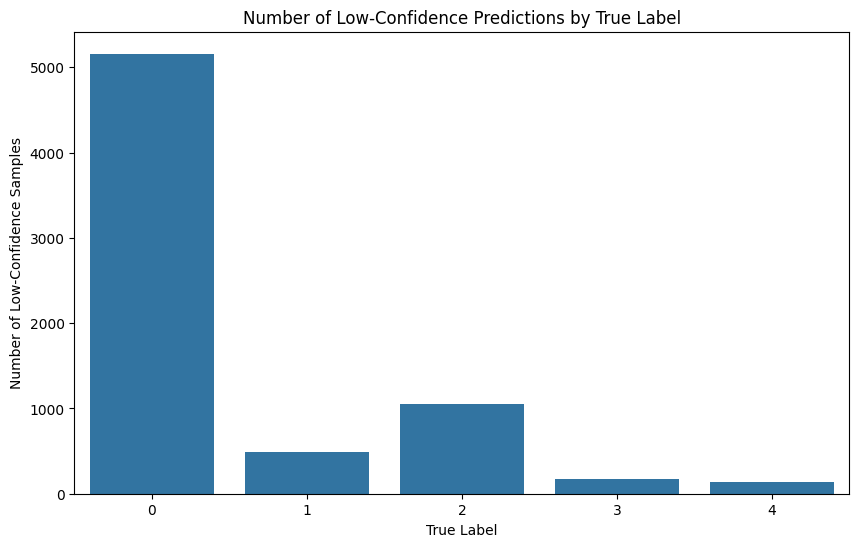

In [20]:
# dem so luong mau co xac suat thap theo label thuc te
low_confidence_counts = low_confidence_df['true_label'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=low_confidence_counts.index, y=low_confidence_counts.values)
plt.xlabel('True Label')
plt.ylabel('Number of Low-Confidence Samples')
plt.title('Number of Low-Confidence Predictions by True Label')
plt.show()

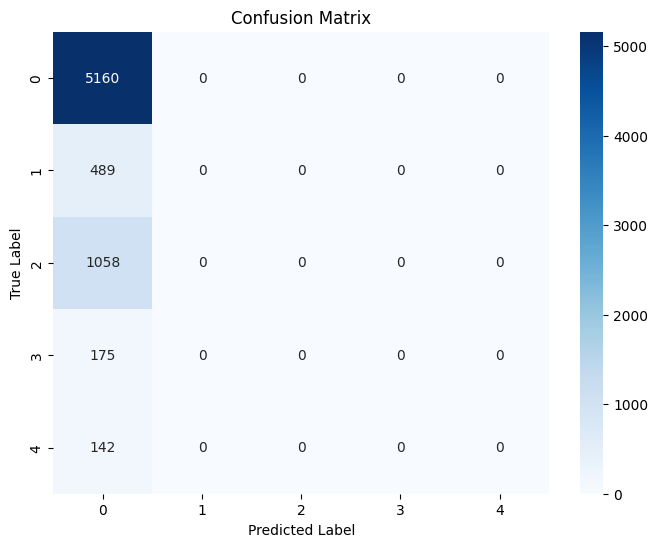

In [21]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

True Label: 2, Predicted Label: 0, Confidence: 0.15


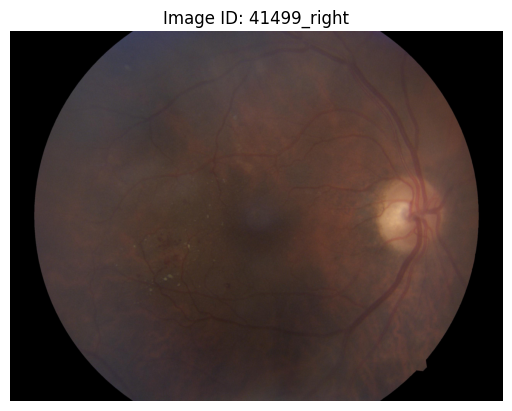

True Label: 1, Predicted Label: 0, Confidence: 0.07


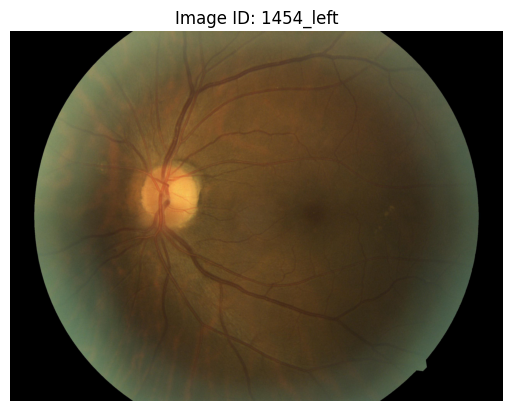

True Label: 0, Predicted Label: 0, Confidence: 0.73


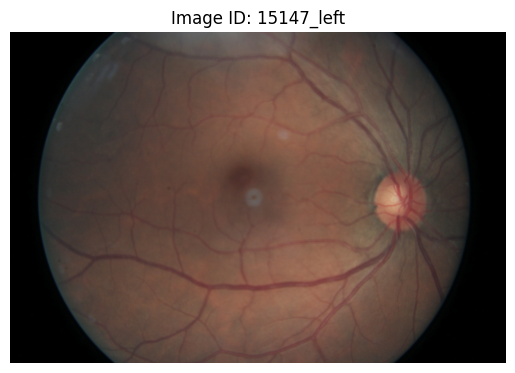

True Label: 0, Predicted Label: 0, Confidence: 0.73


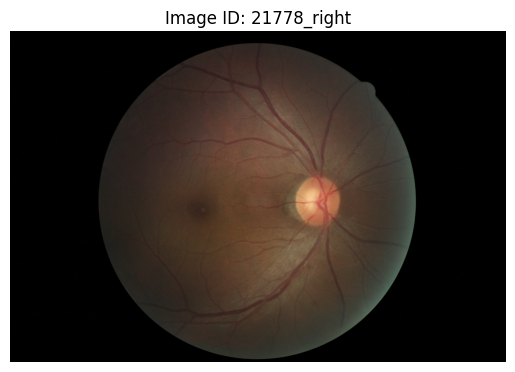

True Label: 0, Predicted Label: 0, Confidence: 0.73


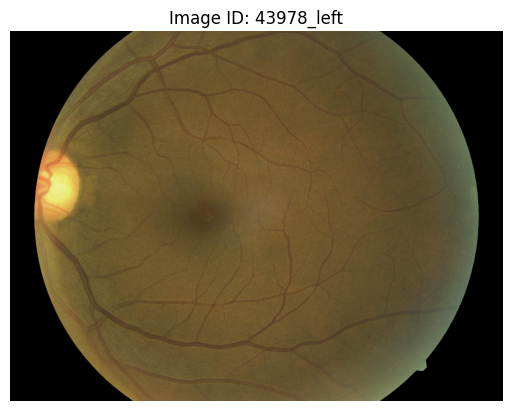

In [22]:
def display_image(image_id, directory='train', itype='.jpeg'):
    img_path = os.path.join(directory, image_id + itype)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f'Image ID: {image_id}')
    plt.axis('off')
    plt.show()

# hien thi anh xac suat thap
for idx, row in low_confidence_df.head(5).iterrows():
    print(f"True Label: {row['true_label']}, Predicted Label: {row['pred_label']}, Confidence: {row['true_label_prob']:.2f}")
    display_image(row['image_id'])

In [ ]:
X_val = []
i=0
for img_id in val_data['id_code']:
    img_path = os.path.join(train_dir, img_id + '.jpeg')  
    img = prepare_image(img_path)  # đã resize và normalize
    X_val.append(img)
    i+=1
    if i ==5 : break


X_val = np.array(X_val)

In [ ]:
X_val

array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],


       [[[0., 0., 0.],
         [0., 0., 0.],
         [0., 